<a href="https://colab.research.google.com/github/allanah1/RNN_Stock_Data/blob/main/RNN_Models_Stock_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.layers import Dense, Activation, Flatten, BatchNormalization, Dropout, GRU, LSTM, Bidirectional
from keras.models import Sequential
from tensorflow.keras import layers

In [ ]:
data = pd.read_csv('q2_dataset.csv') #Assuming the .py file is in the same directory as the dataset

In [ ]:
#Creating new dataset by creating 3 past days of Open, High, Low and Volume of each sample as a feature
#Convert the date column to date format so it's easy to sort according to date
data['Date'] = pd.to_datetime(data['Date'], dayfirst= False)

In [ ]:
data.sort_values('Date', ascending = False, inplace = True)

In [ ]:
#Getting the 3 past days of Volume, Open, High and Low
data['Volume_Previous_Day'] = data[' Volume'].shift(-1)
data['Volume_Previous_2Days'] = data[' Volume'].shift(-2)
data['Volume_Previous_3Days'] = data[' Volume'].shift(-3)
data['Open_Previous_Day'] = data[' Open'].shift(-1)
data['Open_Previous_2Days'] =  data[' Open'].shift(-2)
data['Open_Previous_3Days'] =  data[' Open'].shift(-3)
data['High_Previous_Day'] =  data[' High'].shift(-1)
data['High_Previous_2Days'] = data[' High'].shift(-2)
data['High_Previous_3Days'] = data[' High'].shift(-3)
data['Low_Previous_Day'] = data[' Low'].shift(-1)
data['Low_Previous_2Days'] = data[' Low'].shift(-2)
data['Low_Previous_3Days'] = data[' Low'].shift(-3)

#Getting the next day Open Value as a Column
data['Next_Open'] = data[' Open'].shift(1)

In [ ]:
#New Dataframe with the last 3 days of Volume, High, Open and Low and the next day Open as the target
df =  data.iloc[:,6:]

In [ ]:
#Splitting the created dataframe into 70% train and 30% test
train_X, test_X,  train_Y, test_Y = train_test_split(df.iloc[:,:-1], df.iloc[:, -1], shuffle = True, test_size = 0.3, random_state = 0)

#Saving the train into train_data_RNN.csv and test into test_data_RNN.csv
train = pd.concat([train_X, train_Y], axis = 1)
test = pd.concat([test_X, test_Y], axis = 1)



#train.to_csv('data/train_data_RNN.csv', index = False) #Loacally
#test.to_csv('data/test_data_RNN.csv', index = False) #Locally

In [ ]:
train = pd.read_csv('data/train_data_RNN.csv')

In [ ]:
train.head()

,Volume_Previous_Day,Volume_Previous_2Days,Volume_Previous_3Days,Open_Previous_Day,Open_Previous_2Days,Open_Previous_3Days,High_Previous_Day,High_Previous_2Days,High_Previous_3Days,Low_Previous_Day,Low_Previous_2Days,Low_Previous_3Days,Next_Open
0,23531670.0,22355140.0,20299310.0,139.39,141.50,141.26,141.22,141.74,141.58,138.62,140.35,140.61,143.68
1,28507780.0,27054320.0,11475920.0,110.78,111.43,111.13,112.03,112.47,111.87,110.07,111.39,110.95,110.37
2,32931110.0,38313330.0,22676520.0,177.32,178.65,178.50,177.47,179.12,180.24,173.66,177.62,178.07,175.04
3,30273990.0,33259460.0,29616190.0,156.41,157.50,154.20,156.73,157.88,157.66,152.62,155.98,153.26,154.11
4,41438280.0,51368540.0,32395870.0,174.51,177.25,177.30,174.95,177.30,179.44,170.53,173.20,176.82,170.16


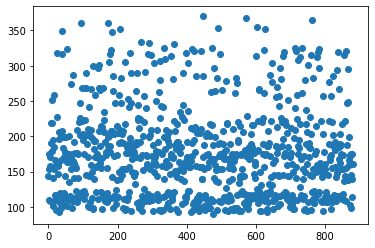

In [ ]:
plt.scatter(train.index, train['Next_Open'])

In [ ]:
train['Next_Open'].min()

90.0

In [ ]:
train['Next_Open'].max()

370.0

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Volume_Previous_Day    880 non-null    float64
 1   Volume_Previous_2Days  879 non-null    float64
 2   Volume_Previous_3Days  878 non-null    float64
 3   Open_Previous_Day      880 non-null    float64
 4   Open_Previous_2Days    879 non-null    float64
 5   Open_Previous_3Days    878 non-null    float64
 6   High_Previous_Day      880 non-null    float64
 7   High_Previous_2Days    879 non-null    float64
 8   High_Previous_3Days    878 non-null    float64
 9   Low_Previous_Day       880 non-null    float64
 10  Low_Previous_2Days     879 non-null    float64
 11  Low_Previous_3Days     878 non-null    float64
 12  Next_Open              880 non-null    float64
dtypes: float64(13)
memory usage: 89.6 KB


In [ ]:
pd.isnull(train).sum()

Volume_Previous_Day      1
Volume_Previous_2Days    2
Volume_Previous_3Days    3
Open_Previous_Day        1
Open_Previous_2Days      2
Open_Previous_3Days      3
High_Previous_Day        1
High_Previous_2Days      2
High_Previous_3Days      3
Low_Previous_Day         1
Low_Previous_2Days       2
Low_Previous_3Days       3
Next_Open                1
dtype: int64

In [ ]:
#Because the number of null values is quite insignificant, all rows with null values is dropped
train.dropna(inplace = True)

In [ ]:
#Splitting the train into inputs and outputs
X = train.iloc[:,:-1].values
y = train.iloc[:, -1].values

#Splitting our train set into train and validation sets
train_X, validation_X, train_y, validation_y = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 0)

In [ ]:
#Normalizing inputs to be between 0 and 1. We basically have only 4 features - Open, High, Volume and Low. VOlume is on a much different scale than the rest so this will be normlaized. 
#Performance will be compared between normalized inputs and inputs without normalization
normalizer = MinMaxScaler()
train_norm_X = normalizer.fit_transform(train_X)
validation_norm_X = normalizer.transform(validation_X)

In [ ]:
#Set random seed to get the same results everytime 
tf.random.set_seed(1234)

In [ ]:
#Reshape input to (number of sample, number of timestep, number of features)
#One timestep because the train data is randomized and the features from previous days are already features for each sample

train_norm_X = train_norm_X.reshape((len(train_norm_X), 1, train_norm_X.shape[1]))
validation_norm_X = validation_norm_X.reshape((len(validation_norm_X), 1, validation_norm_X.shape[1]))

train_X = train_X.reshape((len(train_X), 1, train_X.shape[1]))
validation_X = validation_X.reshape((len(validation_X), 1, validation_X.shape[1]))

In [ ]:
#Building RNN Models 
#GRU models are the latest. We will test out GRU and LSTM models

#LSTM
lstm_model_one = Sequential()
lstm_model_one.add(LSTM(256, input_shape=(1, 12), return_sequences = True))
lstm_model_one.add(Dropout(0.2))
lstm_model_one.add(LSTM(256, return_sequences= True))
lstm_model_one.add(Dropout(0.2))
lstm_model_one.add(LSTM(256))
lstm_model_one.add(Dense(1))


In [ ]:
lstm_model_one.compile(loss='mse', optimizer='adam', metrics = ['mse', 'mape'])

In [ ]:
lstm_history = lstm_model_one.fit(train_norm_X, train_y, epochs = 100, batch_size = 32, validation_data= (validation_norm_X, validation_y))

Epoch 1/100
22/22 [==============================] - 5s 60ms/step - loss: 34341.5065 - mse: 34341.5065 - mape: 99.9046 - val_loss: 32458.2676 - val_mse: 32458.2676 - val_mape: 98.6395
Epoch 2/100
22/22 [==============================] - 0s 8ms/step - loss: 32065.3972 - mse: 32065.3972 - mape: 96.2955 - val_loss: 26512.6855 - val_mse: 26512.6855 - val_mape: 87.1040
Epoch 3/100
22/22 [==============================] - 0s 10ms/step - loss: 25383.0641 - mse: 25383.0641 - mape: 85.0687 - val_loss: 24150.5371 - val_mse: 24150.5371 - val_mape: 80.7465
Epoch 4/100
22/22 [==============================] - 0s 8ms/step - loss: 25471.5736 - mse: 25471.5736 - mape: 80.1798 - val_loss: 22549.4316 - val_mse: 22549.4316 - val_mape: 76.8675
Epoch 5/100
22/22 [==============================] - 0s 8ms/step - loss: 23431.8689 - mse: 23431.8689 - mape: 76.5335 - val_loss: 21181.5254 - val_mse: 21181.5254 - val_mape: 73.4920
Epoch 6/100
22/22 [==============================] - 0s 8ms/step - loss: 21974.1320

In [ ]:
#GRU
gru_model_one = Sequential()
gru_model_one.add(GRU(256, input_shape=(1, 12), return_sequences = True))
gru_model_one.add(Dropout(0.2))
gru_model_one.add(GRU(256, return_sequences= True))
gru_model_one.add(Dropout(0.2))
gru_model_one.add(GRU(256))
gru_model_one.add(Dropout(0.2))
gru_model_one.add(Dense(1))

In [ ]:
gru_model_one.compile(loss='mse', optimizer='adam', metrics = ['mse', 'mape'])
gru_history = gru_model_one.fit(train_norm_X, train_y, epochs = 100, batch_size = 32, validation_data= (validation_norm_X, validation_y))

Epoch 1/100
22/22 [==============================] - 6s 53ms/step - loss: 33922.1255 - mse: 33922.1255 - mape: 99.3100 - val_loss: 28380.8184 - val_mse: 28380.8184 - val_mape: 91.6705
Epoch 2/100
22/22 [==============================] - 0s 7ms/step - loss: 27600.5323 - mse: 27600.5323 - mape: 87.4265 - val_loss: 23718.1094 - val_mse: 23718.1094 - val_mape: 79.6645
Epoch 3/100
22/22 [==============================] - 0s 7ms/step - loss: 22817.7263 - mse: 22817.7263 - mape: 78.5706 - val_loss: 21754.6641 - val_mse: 21754.6641 - val_mape: 74.8549
Epoch 4/100
22/22 [==============================] - 0s 8ms/step - loss: 22945.0070 - mse: 22945.0070 - mape: 74.3377 - val_loss: 20070.2793 - val_mse: 20070.2793 - val_mape: 70.6108
Epoch 5/100
22/22 [==============================] - 0s 7ms/step - loss: 20851.8559 - mse: 20851.8559 - mape: 70.3432 - val_loss: 18590.0469 - val_mse: 18590.0469 - val_mape: 66.7003
Epoch 6/100
22/22 [==============================] - 0s 7ms/step - loss: 19270.6067 

In [ ]:
#Bidirectional LSTM
bidirectional_LSTM = Sequential()
bidirectional_LSTM.add(Bidirectional(LSTM(256, input_shape=(1, 12), return_sequences = True)))
bidirectional_LSTM.add(Dropout(0.2))
bidirectional_LSTM.add(Bidirectional(LSTM(256, return_sequences= True)))
bidirectional_LSTM.add(Dropout(0.2))
bidirectional_LSTM.add(Bidirectional(LSTM(256)))
bidirectional_LSTM.add(Dropout(0.2))
bidirectional_LSTM.add(Dense(1))

In [ ]:
bidirectional_LSTM.compile(loss='mse', optimizer='adam', metrics = ['mse', 'mape'])
bidirectional_LSTM_history = bidirectional_LSTM.fit(train_norm_X, train_y, epochs = 100, batch_size = 32, validation_data= (validation_norm_X, validation_y))

Epoch 1/100
22/22 [==============================] - 13s 117ms/step - loss: 34075.8612 - mse: 34075.8612 - mape: 99.5576 - val_loss: 28379.3945 - val_mse: 28379.3945 - val_mape: 92.5237
Epoch 2/100
22/22 [==============================] - 0s 12ms/step - loss: 26747.8847 - mse: 26747.8847 - mape: 86.4427 - val_loss: 21452.8809 - val_mse: 21452.8809 - val_mape: 74.4140
Epoch 3/100
22/22 [==============================] - 0s 12ms/step - loss: 20324.6257 - mse: 20324.6257 - mape: 72.6018 - val_loss: 18665.4219 - val_mse: 18665.4219 - val_mape: 66.9607
Epoch 4/100
22/22 [==============================] - 0s 12ms/step - loss: 19604.9821 - mse: 19604.9821 - mape: 66.1865 - val_loss: 16402.9258 - val_mse: 16402.9258 - val_mape: 60.5848
Epoch 5/100
22/22 [==============================] - 0s 12ms/step - loss: 16990.6365 - mse: 16990.6365 - mape: 60.1240 - val_loss: 14522.7754 - val_mse: 14522.7754 - val_mape: 54.8437
Epoch 6/100
22/22 [==============================] - 0s 12ms/step - loss: 1497

In [ ]:
#Bidirectional GRU
bidirectional_GRU = Sequential()
bidirectional_GRU.add(Bidirectional(GRU(256, input_shape=(1, 12), return_sequences = True)))
bidirectional_GRU.add(Dropout(0.2))
bidirectional_GRU.add(Bidirectional(GRU(256, return_sequences= True)))
bidirectional_GRU.add(Dropout(0.2))
bidirectional_GRU.add(Bidirectional(GRU(256)))
bidirectional_GRU.add(Dropout(0.2))
bidirectional_GRU.add(Dense(1))

In [ ]:
bidirectional_GRU.compile(loss='mse', optimizer='adam', metrics = ['mse', 'mape'])
bidirectional_GRU_history = bidirectional_GRU.fit(train_norm_X, train_y, epochs = 100, batch_size = 32, validation_data= (validation_norm_X, validation_y))

Epoch 1/100
22/22 [==============================] - 13s 104ms/step - loss: 32698.3370 - mse: 32698.3370 - mape: 97.3919 - val_loss: 22766.3145 - val_mse: 22766.3145 - val_mape: 78.4134
Epoch 2/100
22/22 [==============================] - 0s 11ms/step - loss: 22503.7484 - mse: 22503.7484 - mape: 75.2356 - val_loss: 18870.8047 - val_mse: 18870.8047 - val_mape: 67.4502
Epoch 3/100
22/22 [==============================] - 0s 11ms/step - loss: 17731.4917 - mse: 17731.4917 - mape: 65.6571 - val_loss: 16004.7773 - val_mse: 16004.7773 - val_mape: 59.3496
Epoch 4/100
22/22 [==============================] - 0s 11ms/step - loss: 16786.2929 - mse: 16786.2929 - mape: 58.5183 - val_loss: 13646.9873 - val_mse: 13646.9873 - val_mape: 51.9415
Epoch 5/100
22/22 [==============================] - 0s 13ms/step - loss: 14119.9780 - mse: 14119.9780 - mape: 51.4722 - val_loss: 11730.9678 - val_mse: 11730.9678 - val_mape: 45.2279
Epoch 6/100
22/22 [==============================] - 0s 12ms/step - loss: 1208

**Output of the Training Loop**


*   The training loss and mape are more than the validation loss and mape which is a bit odd
*   Training time was quite short using colab's GPU
* Converting the mse to rmse to get a better sense of the error value, it gives a value of 9.32 from training and 7.4 from validation. This means that are model is only off the real values by those error values. The mape gives better relative values. We are off the real next open day prices by 3.44% on the training set and off the real next open day prices by 2.6% on the validation set



Text(0, 0.5, 'MAPE (%)')

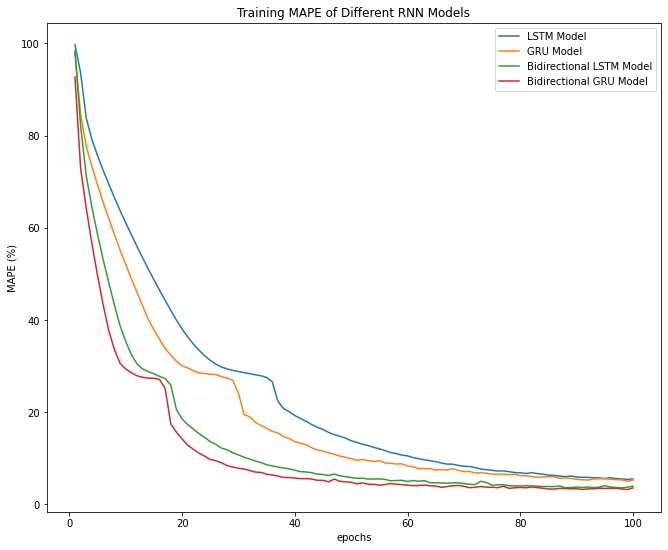

In [ ]:
#Plotting Training MAPE of the Models
models = [lstm_history, gru_history, bidirectional_LSTM_history, bidirectional_GRU_history]
epochs = range(1,101)
plt.figure(figsize = (11,9))
for i in models:
  plt.plot(epochs, i.history['mape'])
plt.title('Training MAPE of Different RNN Models')
plt.legend(['LSTM Model','GRU Model', 'Bidirectional LSTM Model', 'Bidirectional GRU Model'])
plt.xlabel('epochs')
plt.ylabel('MAPE (%)')

Text(0, 0.5, 'RMSE')

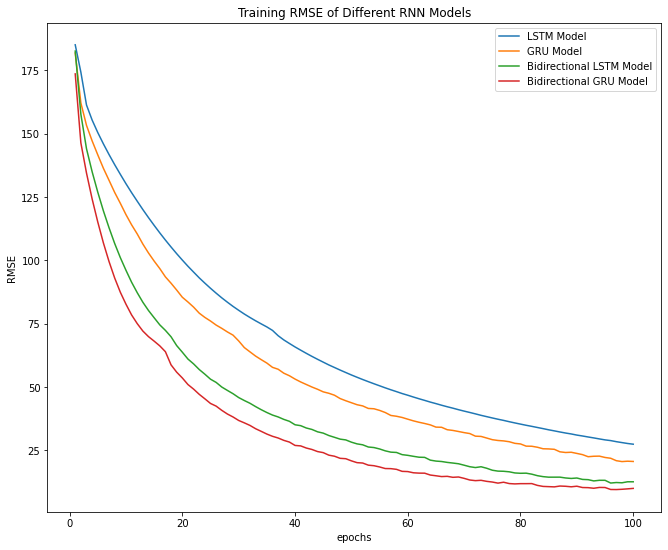

In [ ]:
#Plotting Training RMSE of the Models
models = [lstm_history, gru_history, bidirectional_LSTM_history, bidirectional_GRU_history]
epochs = range(1,101)
plt.figure(figsize = (11,9))
for i in models:
  plt.plot(epochs, np.sqrt(i.history['mse']))
plt.title('Training RMSE of Different RNN Models')
plt.legend(['LSTM Model','GRU Model', 'Bidirectional LSTM Model', 'Bidirectional GRU Model'])
plt.xlabel('epochs')
plt.ylabel('RMSE')

Text(0, 0.5, 'MAPE (%)')

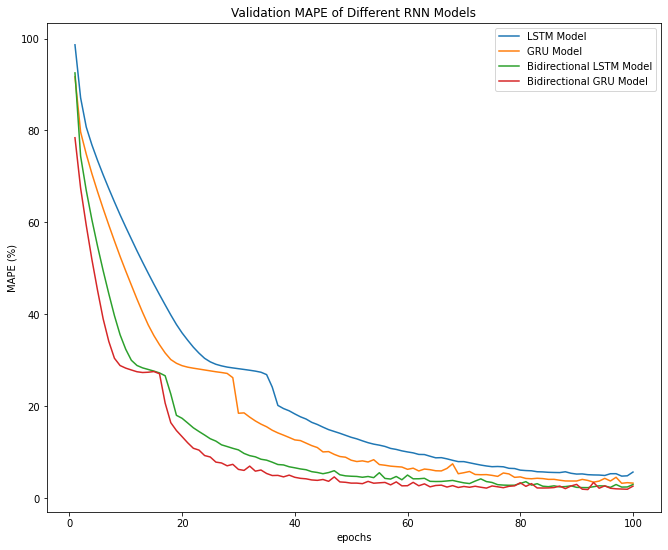

In [ ]:
#Plotting Validation MAPE of the Models
models = [lstm_history, gru_history, bidirectional_LSTM_history, bidirectional_GRU_history]
epochs = range(1,101)
plt.figure(figsize = (11,9))
for i in models:
  plt.plot(epochs, i.history['val_mape'])
plt.title('Validation MAPE of Different RNN Models')
plt.legend(['LSTM Model','GRU Model', 'Bidirectional LSTM Model', 'Bidirectional GRU Model'])
plt.xlabel('epochs')
plt.ylabel('MAPE (%)')

Text(0, 0.5, 'RMSE')

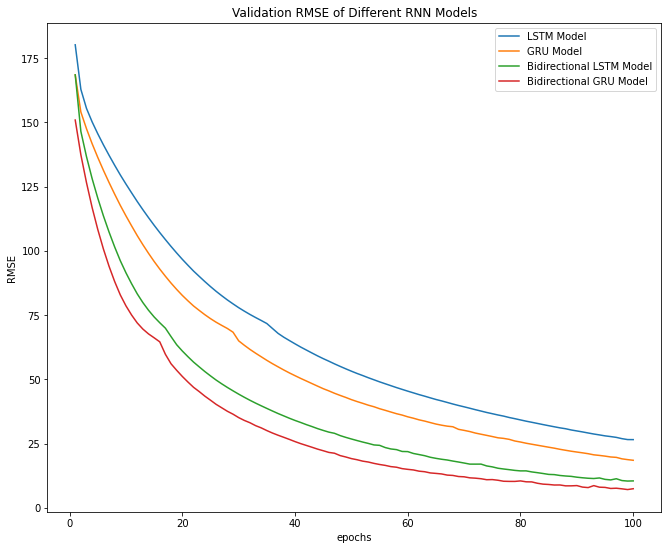

In [ ]:
#Plotting Validation RMSE of the Models
models = [lstm_history, gru_history, bidirectional_LSTM_history, bidirectional_GRU_history]
epochs = range(1,101)
plt.figure(figsize = (11,9))
for i in models:
  plt.plot(epochs, np.sqrt(i.history['val_mse']))
plt.title('Validation RMSE of Different RNN Models')
plt.legend(['LSTM Model','GRU Model', 'Bidirectional LSTM Model', 'Bidirectional GRU Model'])
plt.xlabel('epochs')
plt.ylabel('RMSE')

From the four plots above the best performing model is the bidirectional GRU model therefore this would be saved as our model to be used on the test set

# REPORT


In [ ]:
data.head()

,Date,Close/Last,Volume,Open,High,Low,Volume_Previous_Day,Volume_Previous_2Days,Volume_Previous_3Days,Open_Previous_Day,Open_Previous_2Days,Open_Previous_3Days,High_Previous_Day,High_Previous_2Days,High_Previous_3Days,Low_Previous_Day,Low_Previous_2Days,Low_Previous_3Days,Next_Open
0,2020-07-08,$381.37,29272970,376.72,381.50,376.36,28106110.0,29663910.0,28510370.0,375.41,370.00,367.85,378.62,375.78,370.47,372.23,369.87,363.64,NaN
1,2020-07-07,$372.69,28106110,375.41,378.62,372.23,29663910.0,28510370.0,27684310.0,370.00,367.85,365.12,375.78,370.47,367.36,369.87,363.64,363.91,376.72
2,2020-07-06,$373.85,29663910,370.00,375.78,369.87,28510370.0,27684310.0,35055820.0,367.85,365.12,360.08,370.47,367.36,365.98,363.64,363.91,360.00,375.41
3,2020-07-02,$364.11,28510370,367.85,370.47,363.64,27684310.0,35055820.0,32661520.0,365.12,360.08,353.25,367.36,365.98,362.17,363.91,360.00,351.28,370.00
4,2020-07-01,$364.11,27684310,365.12,367.36,363.91,35055820.0,32661520.0,51314210.0,360.08,353.25,364.41,365.98,362.17,365.32,360.00,351.28,353.02,367.85


**How the dataset was created**


1.   The dataset was first arranged from latest date to the earliest date. 
2.   The previous 3 values of the respective features were created using the python in built shift function which lets you pick the previous value in your dataframe.
3. The date column, close/last, volume, open, high, low features were all dropped resulting in the final dataframe
4. Finally, sci-kit learn's train_test_split function was used to split the dataset into train and test with 70% as the train and shuffle = True to randomize it. Our target input was set to the next day open value and all other remaining features as the input

**Preprocessing Steps**


1.   We normalized all our inputs to ease training.
2.   We set our random seed to get the same output everytime we ran our model
3. We had to reshape our inputs to suitable format for RNN which is (number of samples, number of timesteps, number of features). Our number of timesteps was 1 because we already brought the values of our previous timesteps to be features of each sample. We also shuffled our dataset, so it would not have been wise to look back at the previous value when training.

**Design Steps**


*   We started out with the most popular RNN model types - LSTM and its improvement the GRU model.
* We set our loss to be the mse because it is a regression task and decided to track the mean absolute percentage error as well.
* We tried out simple models of 1 hidden layer with 256 neurons in input and hidden layer using the default tanh activation function and dropout layers with rates of 0.2. After training these 2 models for 50 epochs, we noticed the GRU model performed slightly better, however, we still had high mse loss.
*  We decided to add another hidden layer with the same number of neurons and a dropout layer to prevent overfitting. After doing this we trained for 100 epochs and noticed drastic improvements.
* After doing this, we also decided to try the newer bidirectional models of GRU and LSTM. The validation and training mse and mape values are plotted for the final four models.
* The bidirectional GRU model performed best in both validation and training and was therefore saved as the final model.


**Final Model Architecture**
* 1 input layer of 256 neurons
* 2 hidden layers of 256 neurons
* 1 output layer of 1 neuron
* Activation function for the input and hidden layers are tanh function
* Dropout layers of rate 0.2 were added after each layer except the output layer
* It was trained for 100 epochs
* Batch size of 32
* Optimizer - Adam was used 
* Loss was mean squared error
The model summary is shown below





In [ ]:
bidirectional_GRU.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_18 (Bidirectio (None, 1, 512)            414720    
_________________________________________________________________
dropout_28 (Dropout)         (None, 1, 512)            0         
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 1, 512)            1182720   
_________________________________________________________________
dropout_29 (Dropout)         (None, 1, 512)            0         
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 512)               1182720   
_________________________________________________________________
dropout_30 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)               

If we used more days for features, the model would improve as it is more data whoch essentially means more timesteps for the RNN model. We expect training and validation accuracy to improve 